Tuning opportunities
1. Configuration-Based Hyperparameter Tuning
2. Enhanced Data Augmentation
3. Improved Model Architecture
4. Advanced Callbacks
5. Transfer Learning (Often Best Results)
6. Class Imbalance Handling
7. Ensemble Methods
8. Systematic Tuning Strategy

Quick Start Guide:
For best results immediately: Set "backbone": "mobilenet" and "fine_tune": True
For faster training: Set "backbone": "custom_cnn" and "aug_level": "light"
For maximum accuracy: Enable ensemble with "use_ensemble": True
For experimentation: Uncomment Cell 17 to run systematic tuning

In [7]:
# =======================================================================
# Facial Emotion Recognition - Enhanced with 8 Tuning Improvements
# =======================================================================

import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Python executable: {sys.executable}")

import seaborn as sns

# Deep learning libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Flatten, Dropout, Dense, Input, 
    GlobalAveragePooling2D, Conv2D, 
    BatchNormalization, Activation, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
    ReduceLROnPlateau, LearningRateScheduler)
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

print("✅ All libraries imported successfully")

TensorFlow version: 2.18.0
Python executable: /usr/bin/python3
✅ All libraries imported successfully


In [8]:
# =======================================================================
# Environment Detection
# =======================================================================

def is_on_kaggle():
    """Detect if running on Kaggle."""
    return os.path.exists('/kaggle/input')

def get_data_path():
    """Detect environment and return appropriate data path."""
    if is_on_kaggle():
        print("🌐 Running on Kaggle")
        import kagglehub
        image_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
        folder_path = os.path.join(image_path, "images")
    else:
        print("💻 Running on local machine")
        folder_path = "data/images/"
    
    return folder_path

folder_path = get_data_path()
print(f"Data folder path: {folder_path}")

🌐 Running on Kaggle
Data folder path: /kaggle/input/face-expression-recognition-dataset/images


In [9]:
# =======================================================================
# Enhanced Configuration with Tuning Options
# =======================================================================

cfg = {
    # Model Architecture
    "backbone": "custom_cnn",  # Options: "custom_cnn", "mobilenet", "efficientnet"
    
    # Image Parameters
    "picture_size": 48,  # Try: 64, 96 for more detail
    "color_mode": "grayscale",  # "grayscale" or "rgb" (rgb required for transfer learning)
    
    # Training Parameters
    "batch_size": 128,  # Reduced from 128 for better gradient estimates
    "epochs": 50,  # Increased from 30
    "learning_rate": 3e-4,
    "dropout_rate": 0.5,  # Increased from 0.25
    
    # CNN Architecture (for custom_cnn only)
    "cnn_layers": [
        {"filters": 64, "kernel_size": (3, 3)},
        {"filters": 128, "kernel_size": (3, 3)},
        {"filters": 256, "kernel_size": (3, 3)},
        {"filters": 512, "kernel_size": (3, 3)},
        {"filters": 512, "kernel_size": (3, 3)},
    ],
     
     
    # Dense layers
    "dense_units": [512,256],
    
    # Data Augmentation (Improvement #2)
    "aug_level": "light",  # Options: "none", "light", "strong", "aggressive"
    
    # Advanced Training
    "precision": "mixed",  # "float32" or "mixed"
    "fine_tune": False,  # Enable fine-tuning for transfer learning
    "fine_tune_epochs": 0,
    
    # Optimizer
    "optimizer": "adam",  # Options: "adam", "adamw", "sgd"
    "weight_decay": 1e-4,  # For AdamW
    
    # Learning Rate Schedule
    "use_lr_schedule": False,  # Cosine annealing (Improvement #5)
    
    # Class Weights (Improvement #3)
    "use_class_weights": True,
    
    # Ensemble (Improvement #7)
    "use_ensemble": False,  # Set True to train multiple models
    "n_ensemble_models": 3,
    
    # Model Parameters
    "no_of_classes": 7,
}

print("Configuration loaded:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

# Extract commonly used values
picture_size = cfg["picture_size"]
batch_size = cfg["batch_size"]
epochs = cfg["epochs"]
learning_rate = cfg["learning_rate"]
no_of_classes = cfg["no_of_classes"]

Configuration loaded:
  backbone: custom_cnn
  picture_size: 48
  color_mode: grayscale
  batch_size: 128
  epochs: 50
  learning_rate: 0.0003
  dropout_rate: 0.5
  cnn_layers: [{'filters': 64, 'kernel_size': (3, 3)}, {'filters': 128, 'kernel_size': (3, 3)}, {'filters': 256, 'kernel_size': (3, 3)}, {'filters': 512, 'kernel_size': (3, 3)}, {'filters': 512, 'kernel_size': (3, 3)}]
  dense_units: [512, 256]
  aug_level: light
  precision: mixed
  fine_tune: False
  fine_tune_epochs: 0
  optimizer: adam
  weight_decay: 0.0001
  use_lr_schedule: False
  use_class_weights: True
  use_ensemble: False
  n_ensemble_models: 3
  no_of_classes: 7


In [10]:
# =======================================================================
# Mixed Precision Training
# =======================================================================

from tensorflow.keras import mixed_precision

if cfg.get("precision", "float32") == "mixed":
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed precision training enabled - expect 2-3x speedup!")
else:
    mixed_precision.set_global_policy('float32')
    print("Using float32 precision")

✅ Mixed precision training enabled - expect 2-3x speedup!


In [11]:
# =======================================================================
# Enhanced Data Augmentation
# =======================================================================

aug_map = {
    "none": dict(rescale=1./255),
    
    "light": dict(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    ),
    
    "strong": dict(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        fill_mode='nearest'
    ),
    
    "aggressive": dict(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        brightness_range=[0.6, 1.4],
        horizontal_flip=True,
        channel_shift_range=0.2,
        fill_mode='nearest'
    )
}

# Create data generators
datagen_train = ImageDataGenerator(**aug_map[cfg["aug_level"]])
datagen_validation = ImageDataGenerator(rescale=1./255)

print(f"✅ Using '{cfg['aug_level']}' augmentation level")

✅ Using 'light' augmentation level


In [12]:
# =======================================================================
# Load Training and Validation Data
# =======================================================================

# Determine color mode
color_mode = cfg["color_mode"]

# Create training set
train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

# Create validation set
validation_set = datagen_validation.flow_from_directory(
    os.path.join(folder_path, "validation"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

print(f"\n✅ Data loaded successfully")
print(f"Training samples: {train_set.n}")
print(f"Validation samples: {validation_set.n}")
print(f"Class indices: {train_set.class_indices}")

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.

✅ Data loaded successfully
Training samples: 28821
Validation samples: 7066
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [13]:
# =======================================================================
# Calculate Class Weights for Imbalanced Data
# =======================================================================

class_weight_dict = None

if cfg.get("use_class_weights", False):
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_set.classes),
        y=train_set.classes
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    print("\n✅ Class weights calculated:")
    for emotion, weight in zip(class_labels, class_weights):
        print(f"  {emotion:>10}: {weight:.3f}")
else:
    print("\n⚠️  Class weights disabled")


✅ Class weights calculated:
       Angry: 1.031
     Disgust: 9.443
        Fear: 1.003
       Happy: 0.575
     Neutral: 0.826
         Sad: 0.834
    Surprise: 1.285


In [14]:
# =======================================================================
# Enhanced Model Building Functions
# =======================================================================

def build_improved_cnn(cfg):
    """Enhanced CNN with better architecture."""
    
    picture_size = cfg.get("picture_size", 48)
    no_of_classes = cfg.get("no_of_classes", 7)
    learning_rate = cfg.get("learning_rate", 1e-4)
    dropout_rate = cfg.get("dropout_rate", 0.4)
    
    color_mode = cfg.get("color_mode", "grayscale")
    channels = 1 if color_mode == "grayscale" else 3
    input_shape = (picture_size, picture_size, channels)
    
    model = Sequential()
    
    # Block 1 - Double Conv
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate * 0.5))
    
    # Block 2 - Double Conv
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate * 0.6))
    
    # Block 3 - Double Conv
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate * 0.7))
    
    # Block 4 - Double Conv
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    
    # Dense layers with progressive dropout
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate * 0.7))
    
    # Output layer
    model.add(Dense(no_of_classes, activation='softmax', dtype='float32'))
    
    # Compile with optimizer choice
    optimizer_name = cfg.get("optimizer", "adam")
    if optimizer_name == "adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_name == "adamw":
        opt = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=cfg.get("weight_decay", 1e-4)
        )
    elif optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=0.9,
            nesterov=True
        )
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, None


def build_transfer_learning_model(cfg):
    """Transfer learning with MobileNetV2 or EfficientNetB0 (Improvement #1)."""
    
    picture_size = cfg.get("picture_size", 48)
    no_of_classes = cfg.get("no_of_classes", 7)
    learning_rate = cfg.get("learning_rate", 1e-4)
    
    # Must use RGB for transfer learning
    input_shape = (picture_size, picture_size, 3)
    
    # Choose backbone
    backbone = cfg.get("backbone", "mobilenet")
    
    if backbone == "mobilenet":
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif backbone == "efficientnet":
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Unknown backbone: {backbone}")
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Build model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(no_of_classes, activation='softmax', dtype='float32')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model


# Build model based on configuration
print(f"\n{'='*70}")
print(f"Building model with '{cfg['backbone']}' backbone...")
print(f"{'='*70}")

if cfg["backbone"] in ["mobilenet", "efficientnet"]:
    model, base_model = build_transfer_learning_model(cfg)
else:
    model, base_model = build_improved_cnn(cfg)

print(f"\n✅ Model built successfully")
model.summary()


Building model with 'custom_cnn' backbone...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762571335.693159      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762571335.693950      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



✅ Model built successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 256)    │             

 Total params: 7,187,911 (27.42 MB)

 Trainable params: 7,182,535 (27.40 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [15]:
# =======================================================================
# Advanced Training Callbacks
# =======================================================================

# Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping with more patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased from 5
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  # Increased from 3
    min_lr=1e-7,
    verbose=1
)

# Cosine annealing schedule (Improvement #5)
def cosine_annealing(epoch, lr):
    """Cosine annealing learning rate schedule."""
    import math
    epochs = cfg.get("epochs", 50)
    initial_lr = cfg.get("learning_rate", 1e-4)
    min_lr = 1e-7
    
    if epoch < 5:  # Warmup phase
        return initial_lr * (epoch + 1) / 5
    else:
        progress = (epoch - 5) / (epochs - 5)
        return min_lr + (initial_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

callbacks_list = [checkpoint, early_stopping, reduce_lr]

if cfg.get("use_lr_schedule", False):
    lr_scheduler = LearningRateScheduler(cosine_annealing, verbose=1)
    callbacks_list.append(lr_scheduler)
    print("✅ Using cosine annealing learning rate schedule")

print(f"✅ Callbacks configured: {len(callbacks_list)} callbacks")

✅ Callbacks configured: 3 callbacks


In [16]:
# =======================================================================
# Model Training
# =======================================================================

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)
print(f"Target: {epochs} epochs with early stopping")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Augmentation: {cfg['aug_level']}")
print(f"Backbone: {cfg['backbone']}")
print(f"Class weights: {'Enabled' if class_weight_dict else 'Disabled'}")
print("="*70)

history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=validation_set,
    validation_steps=validation_set.n // validation_set.batch_size,
    callbacks=callbacks_list,
    class_weight=class_weight_dict,  # Improvement #3
    verbose=1
)

print("\n✅ Initial training complete!")


🚀 STARTING TRAINING
Target: 50 epochs with early stopping
Batch size: 128
Learning rate: 0.0003
Augmentation: light
Backbone: custom_cnn
Class weights: Enabled


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1762571348.407902     125 service.cc:148] XLA service 0x7c694400f970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762571348.409787     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762571348.409810     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762571349.822944     125 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-08 03:09:17.625924: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=3} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[128,48,48,64]{3,2,1,0}, f16[128,48,48,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation

  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:38:33 42s/step - accuracy: 0.0781 - loss: 2.2544

I0000 00:00:1762571382.345389     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.1499 - loss: 2.2902
Epoch 1: val_accuracy improved from -inf to 0.01577, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.1499 - loss: 2.2899 - val_accuracy: 0.0158 - val_loss: 2.1352 - learning_rate: 3.0000e-04
Epoch 2/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.1953 - loss: 1.8531

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.01577
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.1953 - loss: 1.8531 - val_accuracy: 0.0158 - val_loss: 2.1292 - learning_rate: 3.0000e-04
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.1756 - loss: 2.0381
Epoch 3: val_accuracy improved from 0.01577 to 0.17116, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 75s 335ms/step - accuracy: 0.1756 - loss: 2.0380 - val_accuracy: 0.1712 - val_loss: 2.1020 - learning_rate: 3.0000e-04
Epoch 4/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2031 - loss: 2.4939
Epoch 4: val_accuracy improved from 0.17116 to 0.17216, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.2031 - loss: 2.4939 - val_accuracy: 0.1722 - val_loss: 2.0995 - learning_rate: 3.0000e-04
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.1901 - loss: 1.9976
Epoch 5: val_accuracy improved from 0.17216 to 0.19673, saving mo

In [17]:
# =======================================================================
# Fine-Tuning Phase (for Transfer Learning)
# =======================================================================

if cfg.get("backbone") in ["mobilenet", "efficientnet"] and cfg.get("fine_tune", False):
    print("\n" + "="*70)
    print("🔧 STARTING FINE-TUNING PHASE")
    print("="*70)
    
    # Unfreeze the last layers
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) - 20  # Unfreeze last 20 layers
    
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    print(f"Unfrozen layers: {sum([1 for layer in base_model.layers if layer.trainable])}")
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Fine-tune for additional epochs
    fine_tune_epochs = cfg.get("fine_tune_epochs", 15)
    
    history_fine = model.fit(
        train_set,
        validation_data=validation_set,
        epochs=fine_tune_epochs,
        callbacks=callbacks_list,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # Merge histories
    for key in history.history.keys():
        history.history[key].extend(history_fine.history[key])
    
    print("✅ Fine-tuning completed!")
else:
    print("\n⚠️  Skipping fine-tuning (only for transfer learning models)")


⚠️  Skipping fine-tuning (only for transfer learning models)


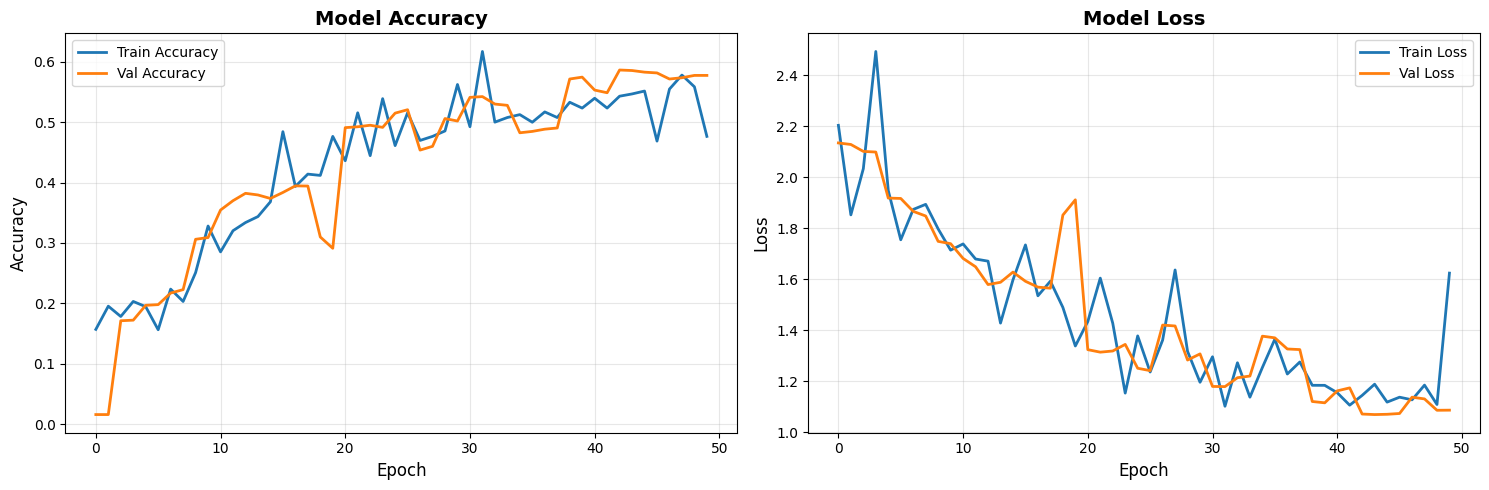


📊 FINAL EVALUATION
Training Accuracy:   0.5855 (58.55%)
Validation Accuracy: 0.5862 (58.62%)
Training Loss:       1.0833
Validation Loss:     1.0682


In [18]:
# =======================================================================
# Training History Visualization
# =======================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Final evaluation
print("\n" + "="*70)
print("📊 FINAL EVALUATION")
print("="*70)
train_loss, train_acc = model.evaluate(train_set, verbose=0)
val_loss, val_acc = model.evaluate(validation_set, verbose=0)

print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Loss:     {val_loss:.4f}")
print("="*70)

In [19]:
# =======================================================================
# Detailed Performance Analysis
# =======================================================================

from keras.models import load_model

# Load best model
my_model = load_model('best_model.keras', compile=False)

# Get predictions
print("Generating predictions on validation set...")
validation_set.reset()
predictions = my_model.predict(validation_set, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_set.classes

# Calculate metrics
accuracy = np.mean(predicted_classes == true_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(f"\n✅ Best Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Generating predictions on validation set...
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step

✅ Best Model Accuracy: 0.5870 (58.70%)


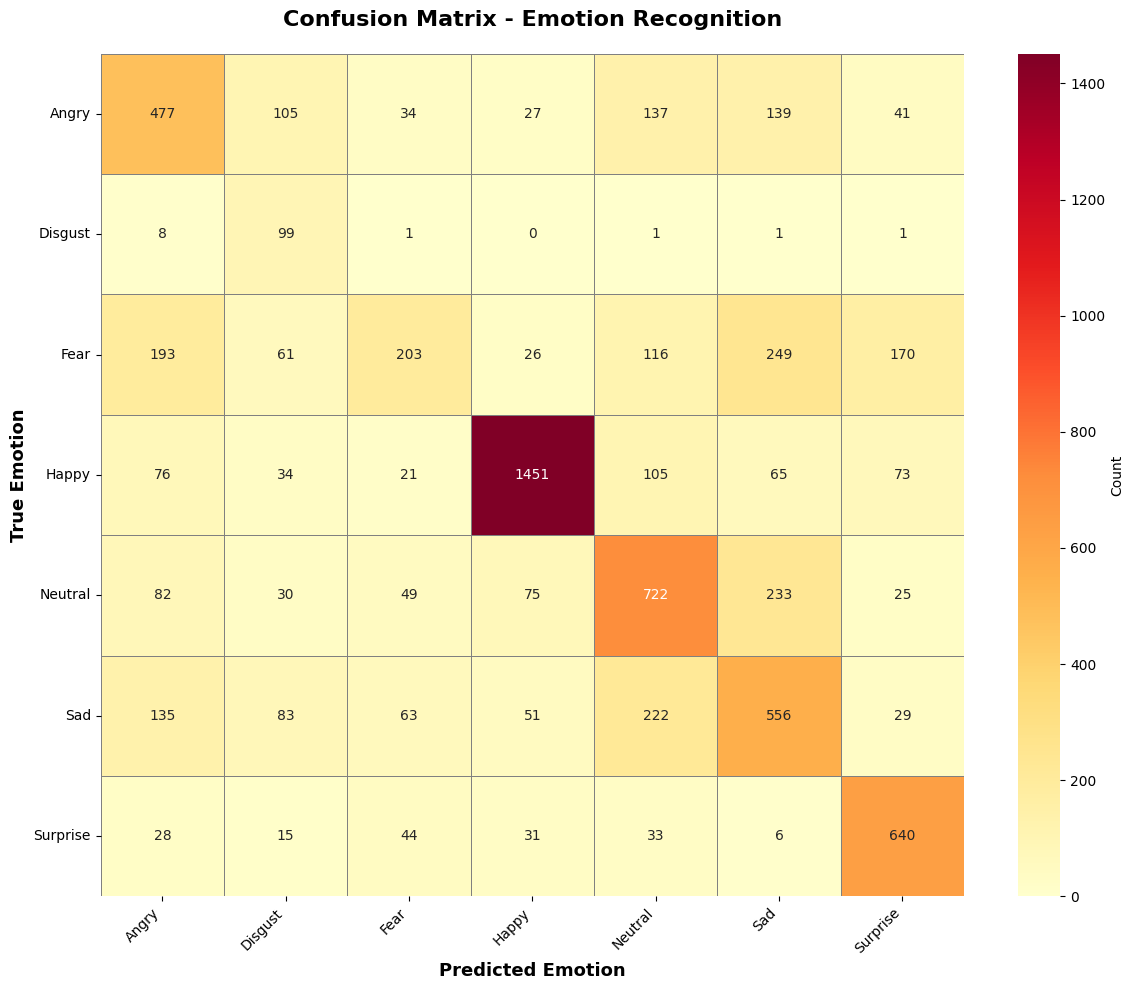

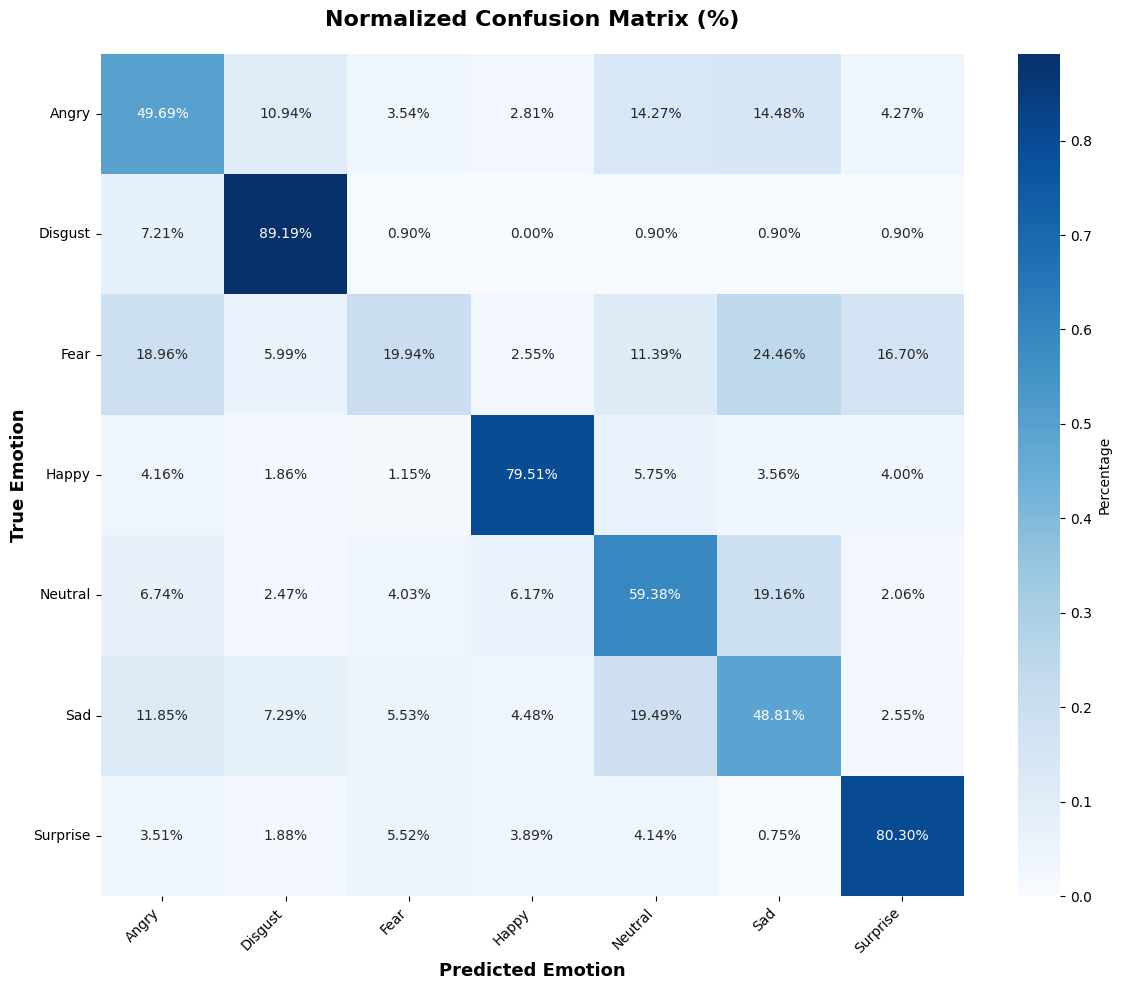


📈 DETAILED CLASSIFICATION METRICS
              precision    recall  f1-score   support

       Angry     0.4775    0.4969    0.4870       960
     Disgust     0.2319    0.8919    0.3680       111
        Fear     0.4892    0.1994    0.2833      1018
       Happy     0.8736    0.7951    0.8325      1825
     Neutral     0.5404    0.5938    0.5658      1216
         Sad     0.4452    0.4881    0.4657      1139
    Surprise     0.6537    0.8030    0.7207       797

    accuracy                         0.5870      7066
   macro avg     0.5302    0.6097    0.5319      7066
weighted avg     0.6031    0.5870    0.5815      7066



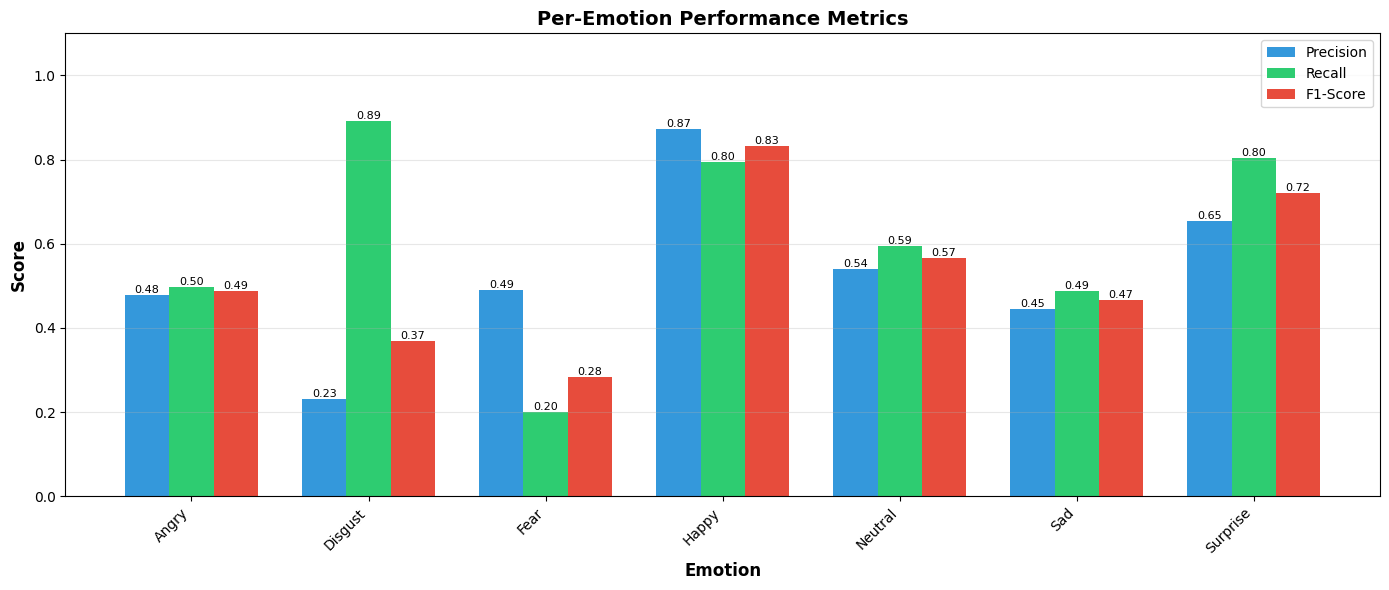


📊 PERFORMANCE SUMMARY TABLE
 Emotion Precision Recall F1-Score  Support
   Angry    47.75% 49.69%   48.70%      960
 Disgust    23.19% 89.19%   36.80%      111
    Fear    48.92% 19.94%   28.33%     1018
   Happy    87.36% 79.51%   83.25%     1825
 Neutral    54.04% 59.38%   56.58%     1216
     Sad    44.52% 48.81%   46.57%     1139
Surprise    65.37% 80.30%   72.07%      797

⚠️  TOP 5 MISCLASSIFICATION PAIRS
      Fear → Sad        :  249 times
   Neutral → Sad        :  233 times
       Sad → Neutral    :  222 times
      Fear → Angry      :  193 times
      Fear → Surprise   :  170 times


In [20]:
# =======================================================================
# Enhanced Performance Visualizations
# =======================================================================

# 1. Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Confusion Matrix - Emotion Recognition', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Classification Report
print("\n" + "="*70)
print("📈 DETAILED CLASSIFICATION METRICS")
print("="*70)
print(classification_report(true_classes, predicted_classes, 
                           target_names=class_labels,
                           digits=4))

# 4. Per-Class Metrics Bar Chart
precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, labels=range(7)
)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(class_labels))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Emotion', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Emotion Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Summary Table
summary_df = pd.DataFrame({
    'Emotion': class_labels,
    'Precision': [f'{p:.2%}' for p in precision],
    'Recall': [f'{r:.2%}' for r in recall],
    'F1-Score': [f'{f:.2%}' for f in f1],
    'Support': support.astype(int)
})

print("\n" + "="*70)
print("📊 PERFORMANCE SUMMARY TABLE")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# 6. Misclassification Analysis
misclassified = cm.copy()
np.fill_diagonal(misclassified, 0)

top_confusions = []
for i in range(7):
    for j in range(7):
        if i != j:
            top_confusions.append((class_labels[i], class_labels[j], misclassified[i, j]))

top_confusions.sort(key=lambda x: x[2], reverse=True)

print("\n" + "="*70)
print("⚠️  TOP 5 MISCLASSIFICATION PAIRS")
print("="*70)
for true_label, pred_label, count in top_confusions[:5]:
    print(f"{true_label:>10} → {pred_label:<10} : {count:>4} times")
print("="*70)

In [21]:
# =======================================================================
# Save Model with Timestamp
# =======================================================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"emotion_recognition_{timestamp}.keras"

if is_on_kaggle():
    output_path = "/kaggle/working/"
else:
    output_path = "."

full_path = Path(output_path) / model_name
model.save(str(full_path))

print(f"\n💾 Model saved: {full_path}")
print(f"📊 Final Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")


💾 Model saved: /kaggle/working/emotion_recognition_20251108_034839.keras
📊 Final Validation Accuracy: 0.5862 (58.62%)


In [22]:
# =======================================================================
# Ensemble Training (Optional)
# =======================================================================

if cfg.get("use_ensemble", False):
    print("\n" + "="*70)
    print("🎯 TRAINING ENSEMBLE MODELS")
    print("="*70)
    
    n_models = cfg.get("n_ensemble_models", 3)
    ensemble_models = []
    
    for i in range(n_models):
        print(f"\n{'='*70}")
        print(f"Training Ensemble Model {i+1}/{n_models}")
        print(f"{'='*70}")
        
        # Vary hyperparameters slightly
        cfg_copy = cfg.copy()
        cfg_copy["learning_rate"] = cfg["learning_rate"] * (0.8 + 0.4 * np.random.random())
        cfg_copy["dropout_rate"] = 0.3 + 0.2 * np.random.random()
        
        # Build model
        if cfg["backbone"] in ["mobilenet", "efficientnet"]:
            ensemble_model, _ = build_transfer_learning_model(cfg_copy)
        else:
            ensemble_model, _ = build_improved_cnn(cfg_copy)
        
        # Train
        history_ens = ensemble_model.fit(
            train_set,
            validation_data=validation_set,
            epochs=30,
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )
        
        ensemble_models.append(ensemble_model)
        
        # Save
        ensemble_model.save(f"ensemble_model_{i+1}.keras")
    
    # Ensemble prediction
    print("\n" + "="*70)
    print("🎯 ENSEMBLE PREDICTION")
    print("="*70)
    
    validation_set.reset()
    ensemble_predictions = []
    
    for i, ens_model in enumerate(ensemble_models):
        print(f"Getting predictions from model {i+1}...")
        pred = ens_model.predict(validation_set, verbose=0)
        ensemble_predictions.append(pred)
    
    # Average predictions
    avg_predictions = np.mean(ensemble_predictions, axis=0)
    ensemble_predicted_classes = np.argmax(avg_predictions, axis=1)
    
    # Evaluate ensemble
    ensemble_accuracy = np.mean(ensemble_predicted_classes == true_classes)
    
    print(f"\n✅ Ensemble Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
    print(f"📈 Improvement over single model: {(ensemble_accuracy - accuracy)*100:.2f}%")
else:
    print("\n⚠️  Ensemble training disabled (set 'use_ensemble': True to enable)")


⚠️  Ensemble training disabled (set 'use_ensemble': True to enable)


In [ ]:
# =======================================================================
# Sample Predictions Visualization
# =======================================================================
import random

# Get a random batch from validation set
random_batch_idx = random.randint(0, len(validation_set) - 1)
sample_images, sample_labels = validation_set[random_batch_idx]

# Predict
sample_preds = my_model.predict(sample_images, verbose=0)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

# Randomly select 16 indices from the batch
num_samples = min(16, len(sample_images))
random_indices = random.sample(range(len(sample_images)), num_samples)

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    axes[i].imshow(sample_images[idx].squeeze(), cmap='gray')
    
    true_label = class_labels[sample_true_classes[idx]]
    pred_label = class_labels[sample_pred_classes[idx]]
    confidence = sample_preds[idx][sample_pred_classes[idx]] * 100

    # Color: green if correct, red if wrong
    color = 'green' if sample_true_classes[idx] == sample_pred_classes[idx] else 'red'
    
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions on Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()